In [108]:
from funciones import *
from skforecast import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sns.set()

In [109]:
df = pd.read_excel('pvasco_todos.xlsx')
df_CPV = pd.read_excel('CPV.xlsx')

In [110]:
df_copy = df.copy()

In [111]:
contratos = ["Contratación de personas físicas y jurídicas para la prestación de servicios del Programa de Asistencia Dental Infantil (PADI) con consulta en el Territorio Histórico de Gipuzkoa","Contratación de los servicios del Programa de Asistencia Dental Infantil (PADI) del Área de Salud de Araba/Álava. ","La contratación de personas físicas y jurídicas para la prestación de servicios del Programa de Asistencia Dental Infantil (PADI) con consulta en el Territorio Histórico de Bizkaia"]

# EDA

In [112]:
df_copy = procesar_contratos(df_copy, contratos)
df_copy = unificar_lotes(df_copy)
df_copy = filtrar_procedimientos_adjudicacion(df_copy)

In [113]:
#X= Fecha de adjudicación, Y=CPV
columnas = ['Fecha de adjudicación ','CPV']
df1 = df_copy[columnas].copy()
#gestión de nulos
df1 = df1.fillna(value=np.nan)

In [114]:
#Transformo CPV a los 2 primeros digitos
df_CPV['CPV'] = df_CPV['CPV'].apply(lambda x: str(x)[:2])
df1 = df1.rename(columns={'Fecha de adjudicación ': 'fecha_adjudicacion'})
df1 = convertir_fecha(df1, 'fecha_adjudicacion')

In [115]:
#Rellenar con todas las fechas de mi periodo de tiempo
df1['fecha_adjudicacion'] = pd.to_datetime(df1['fecha_adjudicacion'])
all_dates = pd.date_range(start='2015-01-01', end='2023-11-30') 
df_dates = pd.DataFrame(all_dates, columns=['fecha_adjudicacion'])
df1 = pd.merge(df_dates, df1, on='fecha_adjudicacion', how='left')

In [116]:
df1['CPV_div'] = df1['CPV'].apply(lambda x: str(x)[:2]) 
dict_CPV_ES = df_CPV.set_index('CPV')['ES'].to_dict()
cpv_sector = dict_CPV_ES
df1['CPV_sector'] = df1['CPV'].str[0:2]
# Renombrar el primer dígito del CPV según el nombre del sector usando el diccionario
df1['CPV_sector'] = df1['CPV_sector'].map(cpv_sector)
df1 = df1.drop(['CPV','CPV_div'], axis=1)

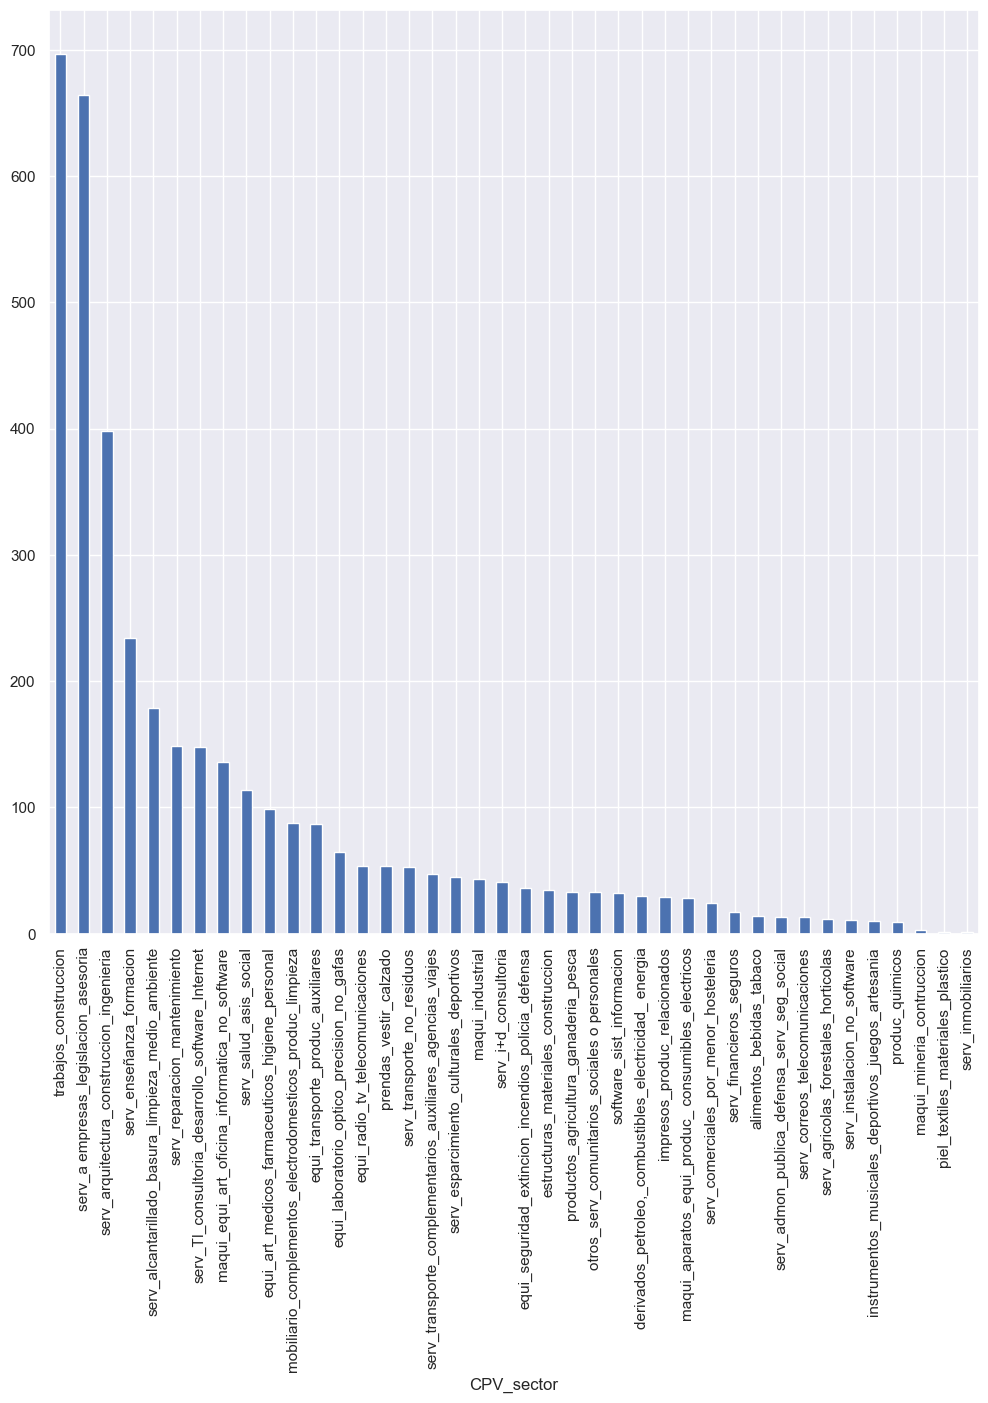

In [117]:
#Muestra distribución todos los CPV
df1['CPV_sector'].value_counts().plot(kind='bar')
plt.show()

In [118]:
#Muestra los 5 primeros
visualizar_conteo(df1, ['CPV_sector'])

Conteo de Valores, Porcentaje y Porcentaje Acumulado para CPV_sector:


,Conteo,Porcentaje (%),Porcentaje Acumulado (%)
CPV_sector,,,
trabajos_construccion,697,18.44,18.44
serv_a empresas_legislacion_asesoria,664,17.57,36.01
serv_arquitectura_construccion_ingenieria,398,10.53,46.54
serv_enseñanza_formacion,234,6.19,52.73
serv_alcantarillado_basura_limpieza_medio_ambiente,179,4.74,57.47


In [119]:
#selecciono los 4 primeros- en fases posteriores vi que el quinto era mejor no utilizarlo
valores_seleccionados = seleccionar_valores_altos(df1, ['CPV_sector'], porcentaje_corte=6)
df_grouped = pd.DataFrame(index=df1['fecha_adjudicacion'].unique())
for valor in valores_seleccionados:
    df_filtrado = df1[df1['CPV_sector'] == valor]
    conteo = df_filtrado.groupby('fecha_adjudicacion').size()
    df_grouped[valor] = conteo
df_grouped.fillna(0, inplace=True)

In [120]:
#Algunas visualizaciones previas
mensual = df_grouped.resample('M').mean()
columnas = df_grouped.columns.tolist()

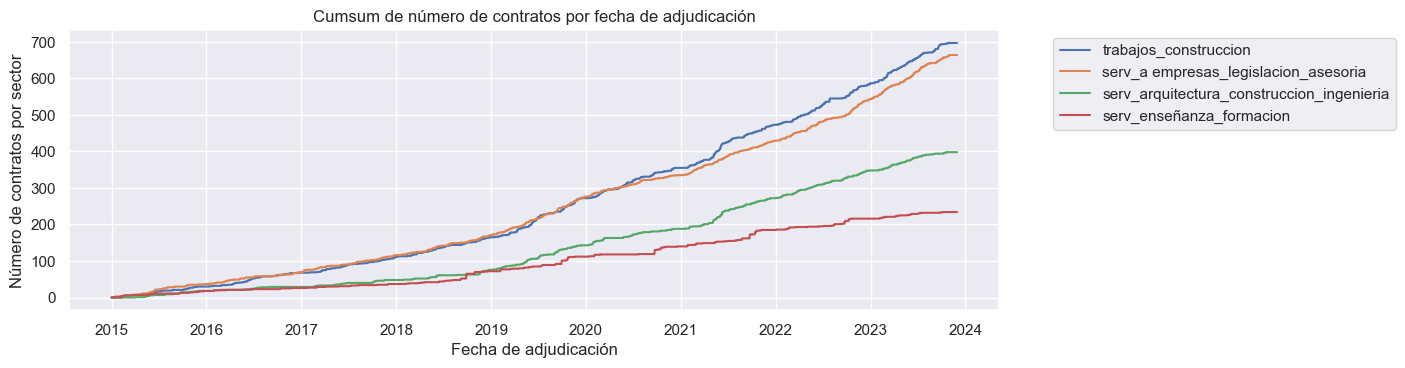

<Figure size 1200x1200 with 0 Axes>

In [121]:
dfs = [(df_grouped, columnas, 'Cumsum de número de contratos por fecha de adjudicación')]

plt.figure(figsize = (12,8))

for i, (df, cols, titulo) in enumerate(dfs, 1): #empieza a contar en 1 por el subplot
    plt.subplot(2, 1, i)
    generar_grafico(df, cols, titulo)

plt.tight_layout()
plt.show()

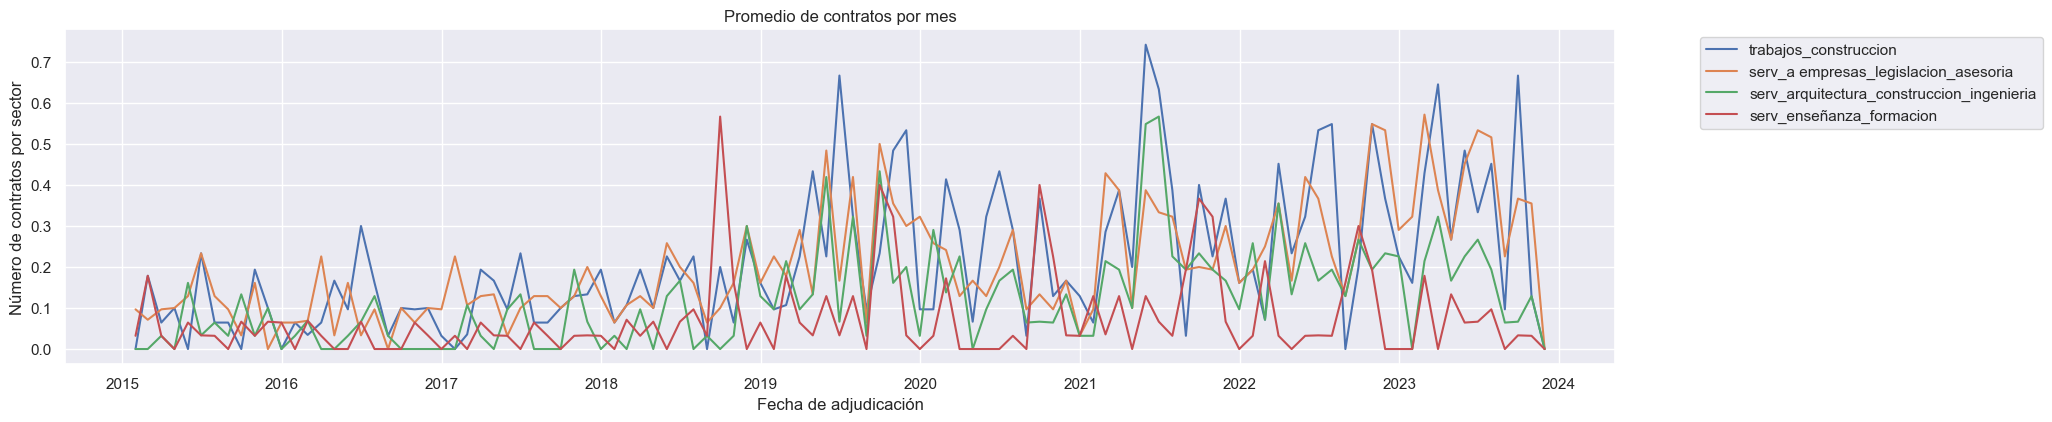

<Figure size 1200x1200 with 0 Axes>

In [122]:
#en fase de exploración también se probó con semanal y trimestral
dfs = [(mensual, 'Promedio de contratos por mes')]
for i, (df, titulo) in enumerate(dfs, 1):
    plt.figure(figsize = (20,20))
    plt.subplot(4, 1, i)
    generar_grafico_V1(df,columnas, titulo)

plt.tight_layout()
plt.show()

In [123]:
#Resampleo por mes y rolling window por un año
ventana = 12
resampleados = {}
promedios = {}

for nombre in columnas:
    resampleados[nombre] = df_grouped[nombre].resample('M').sum() 
    resampleados[nombre] = resampleados[nombre].replace([np.inf, -np.inf], np.nan).interpolate()
    promedios[nombre] = resampleados[nombre].rolling(window=ventana, center=False).mean()
promedio = pd.DataFrame(promedios) #a partir de este dataframe hacemos el entreno posterior
promedio = promedio.dropna()

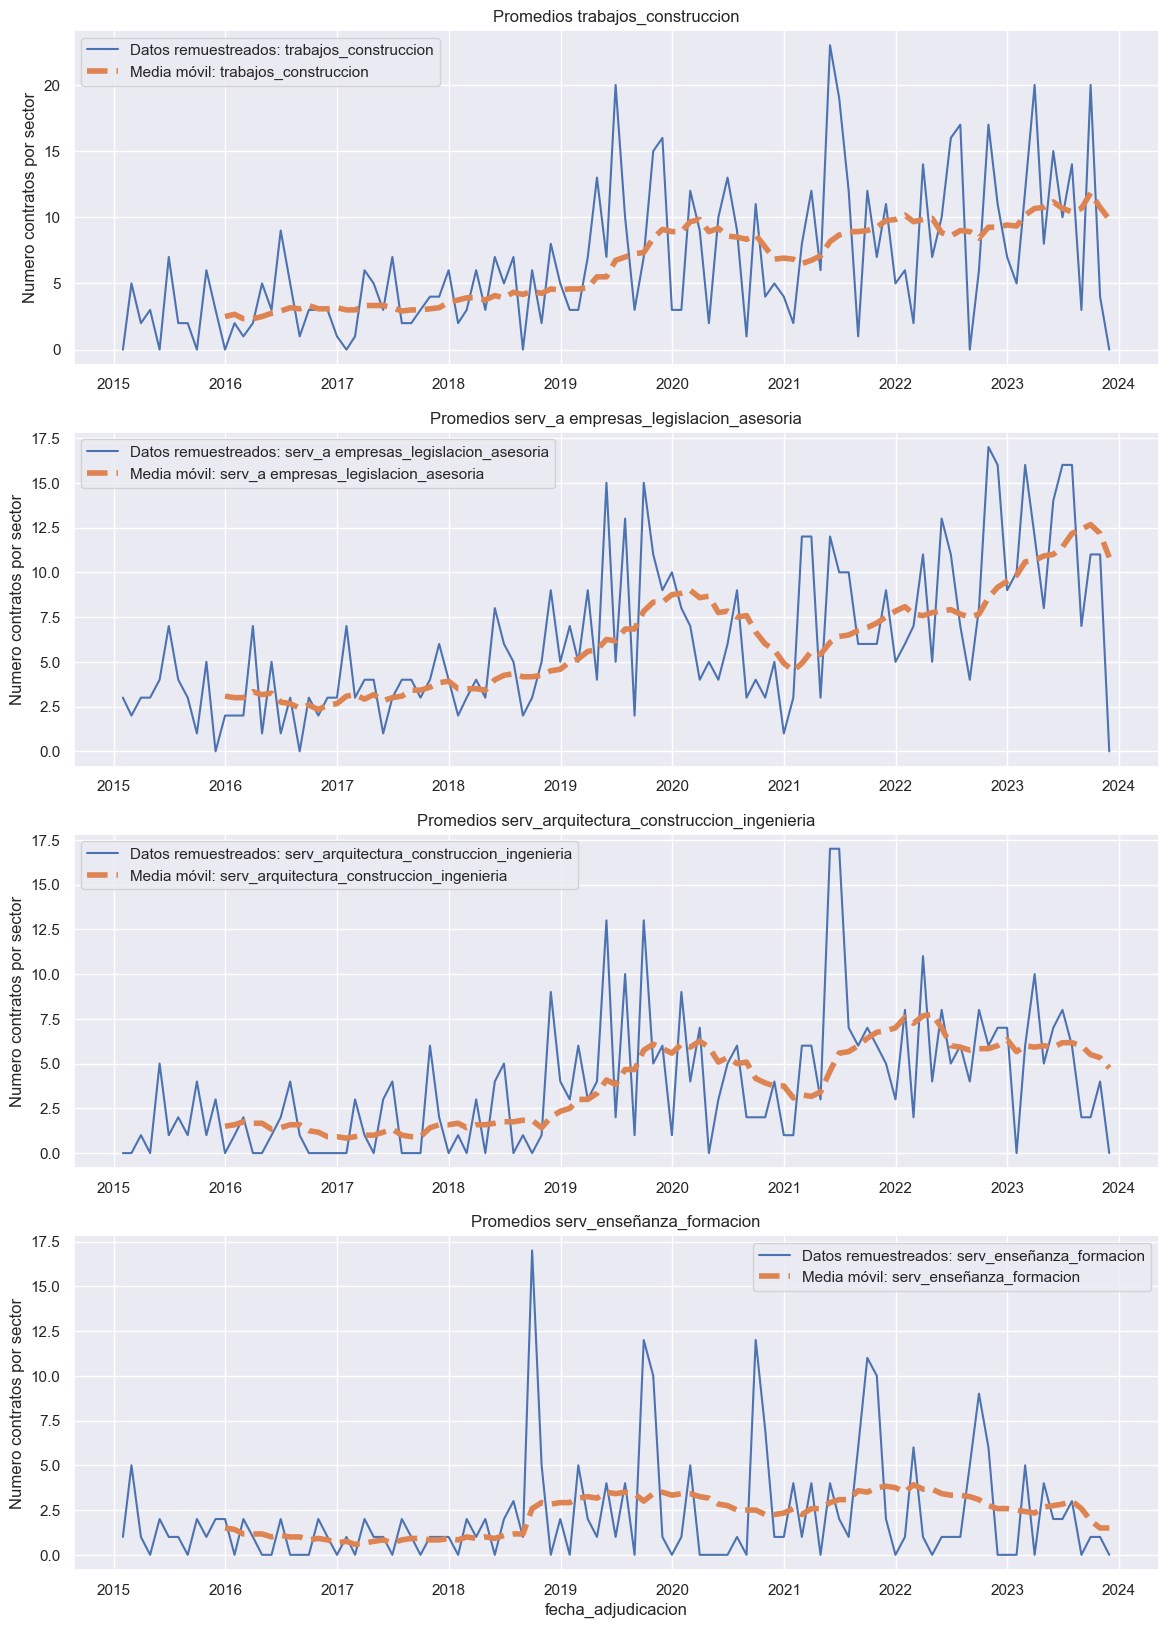

In [124]:
total_subplots = len(resampleados)
plt.figure(figsize = (14,20))
for i, nombre in enumerate(resampleados.keys()):
    generar_grafico_v2(resampleados[nombre], promedios[nombre], nombre, i+1, total_subplots)

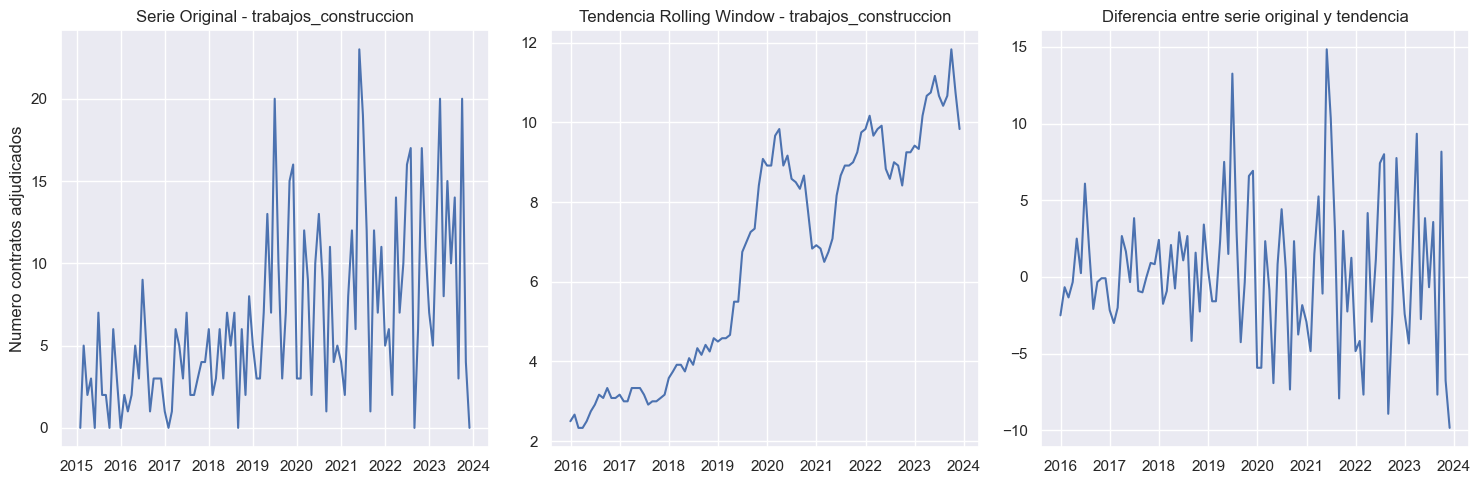

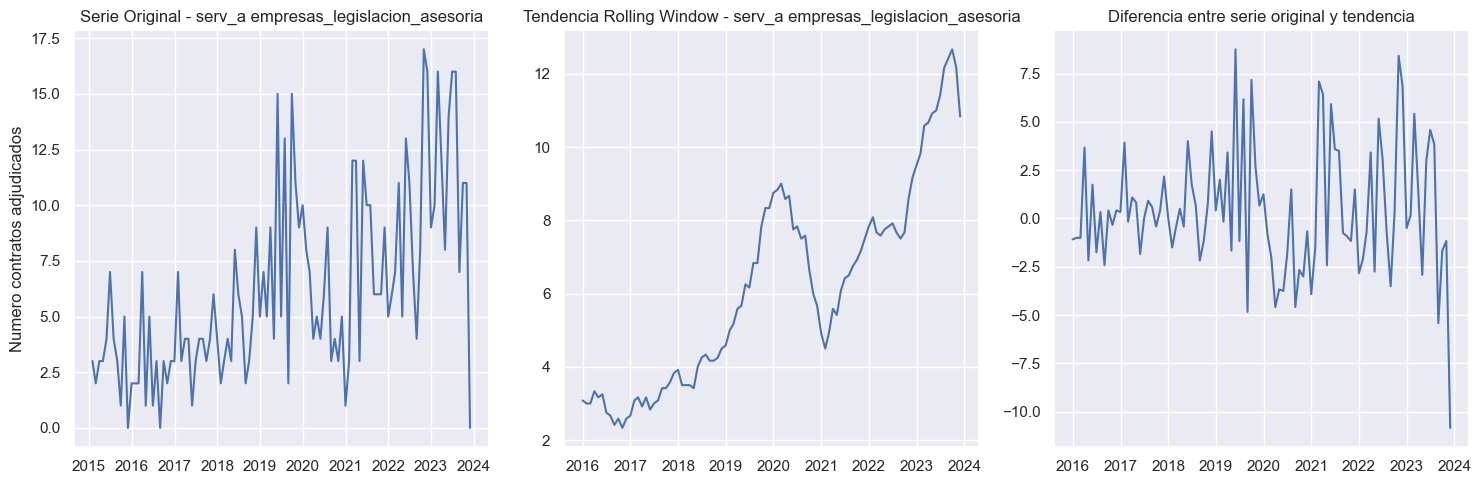

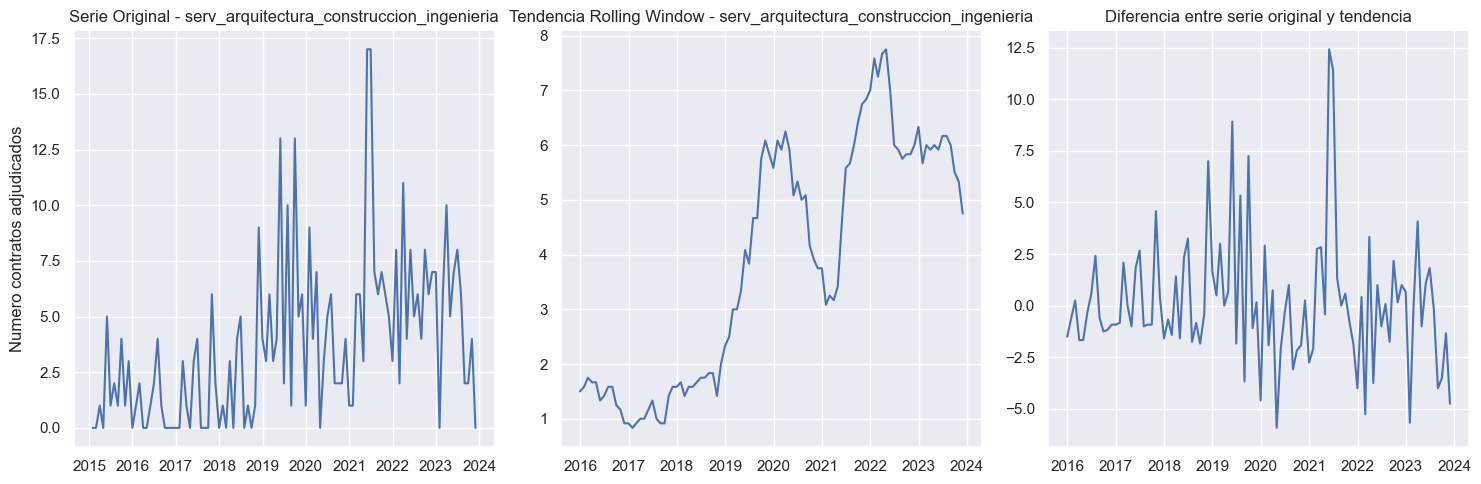

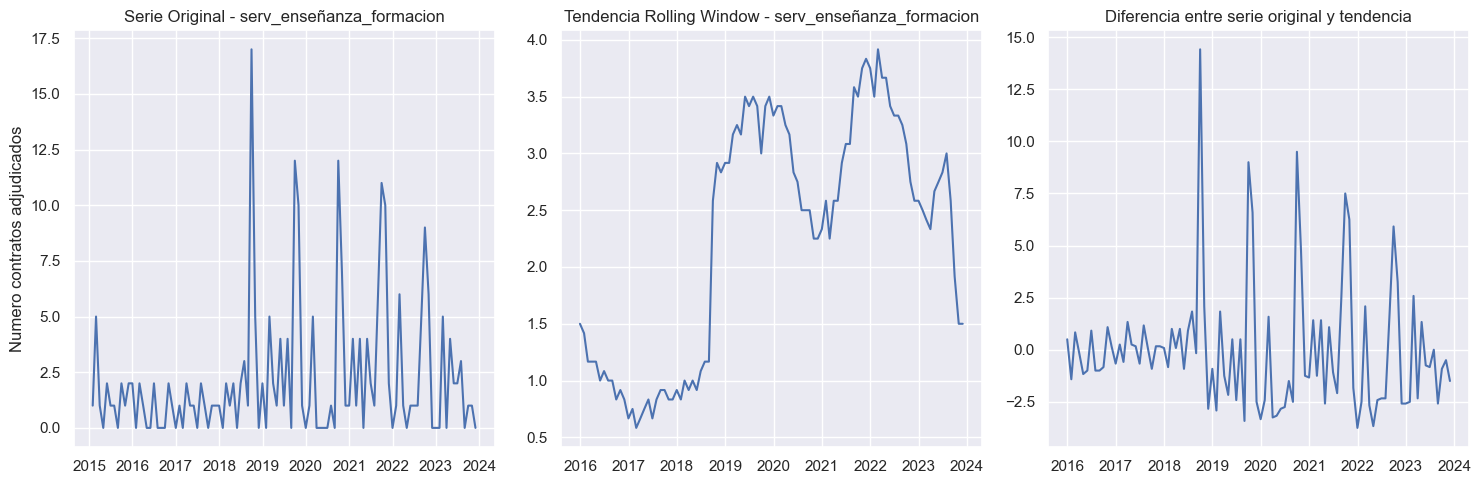

In [125]:
for key in resampleados.keys():
    graficar_componentes(key, resampleados, promedios)

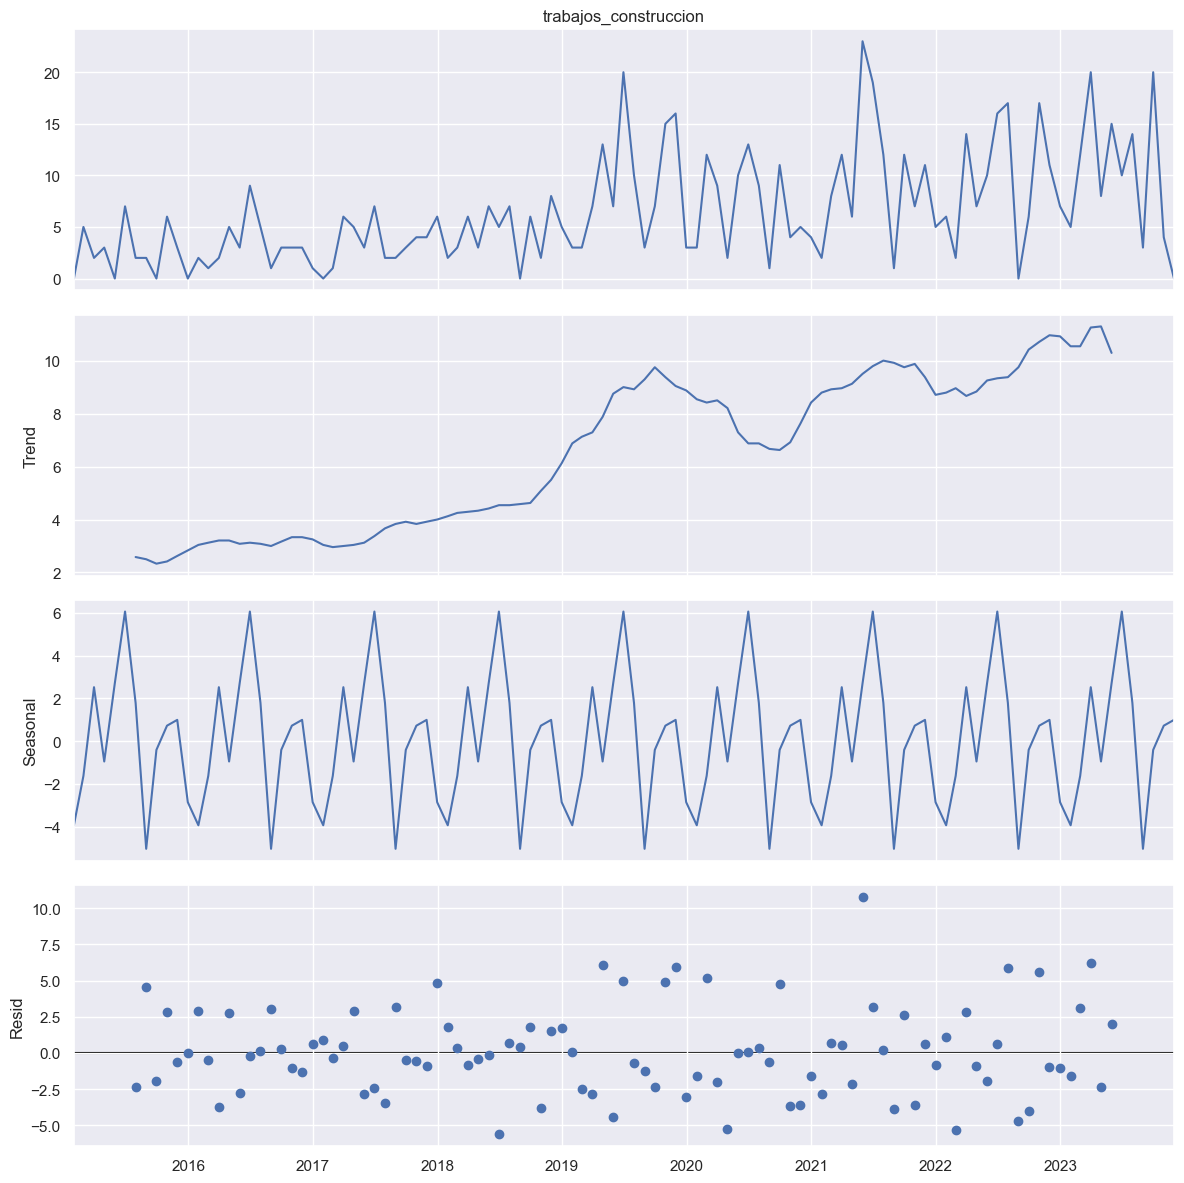

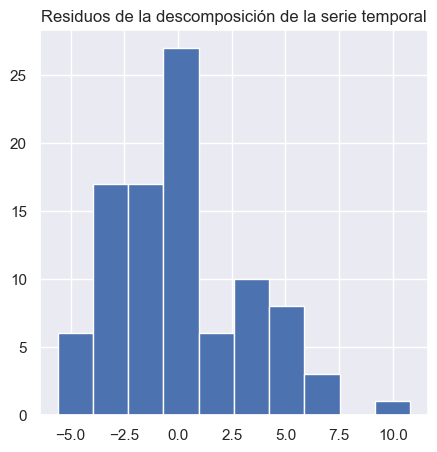

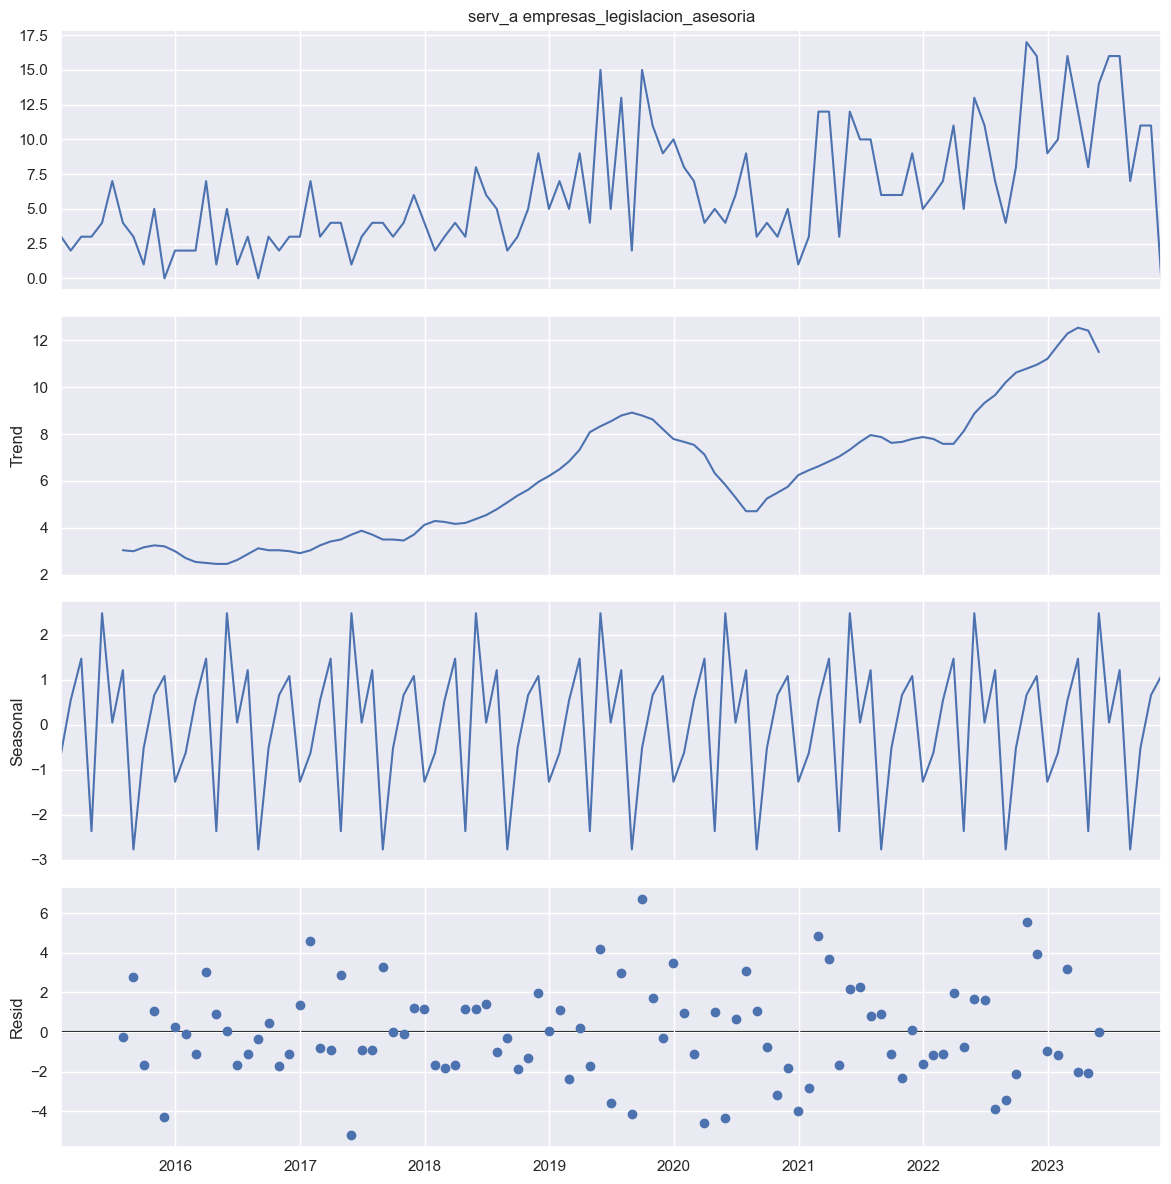

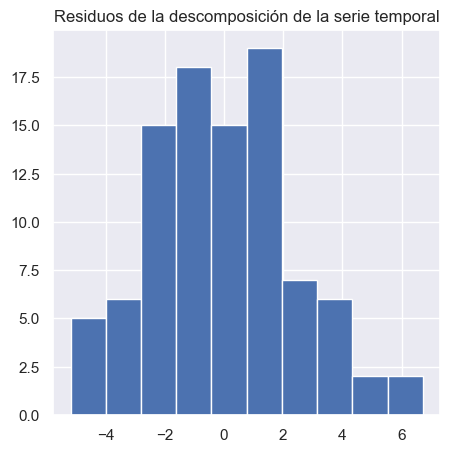

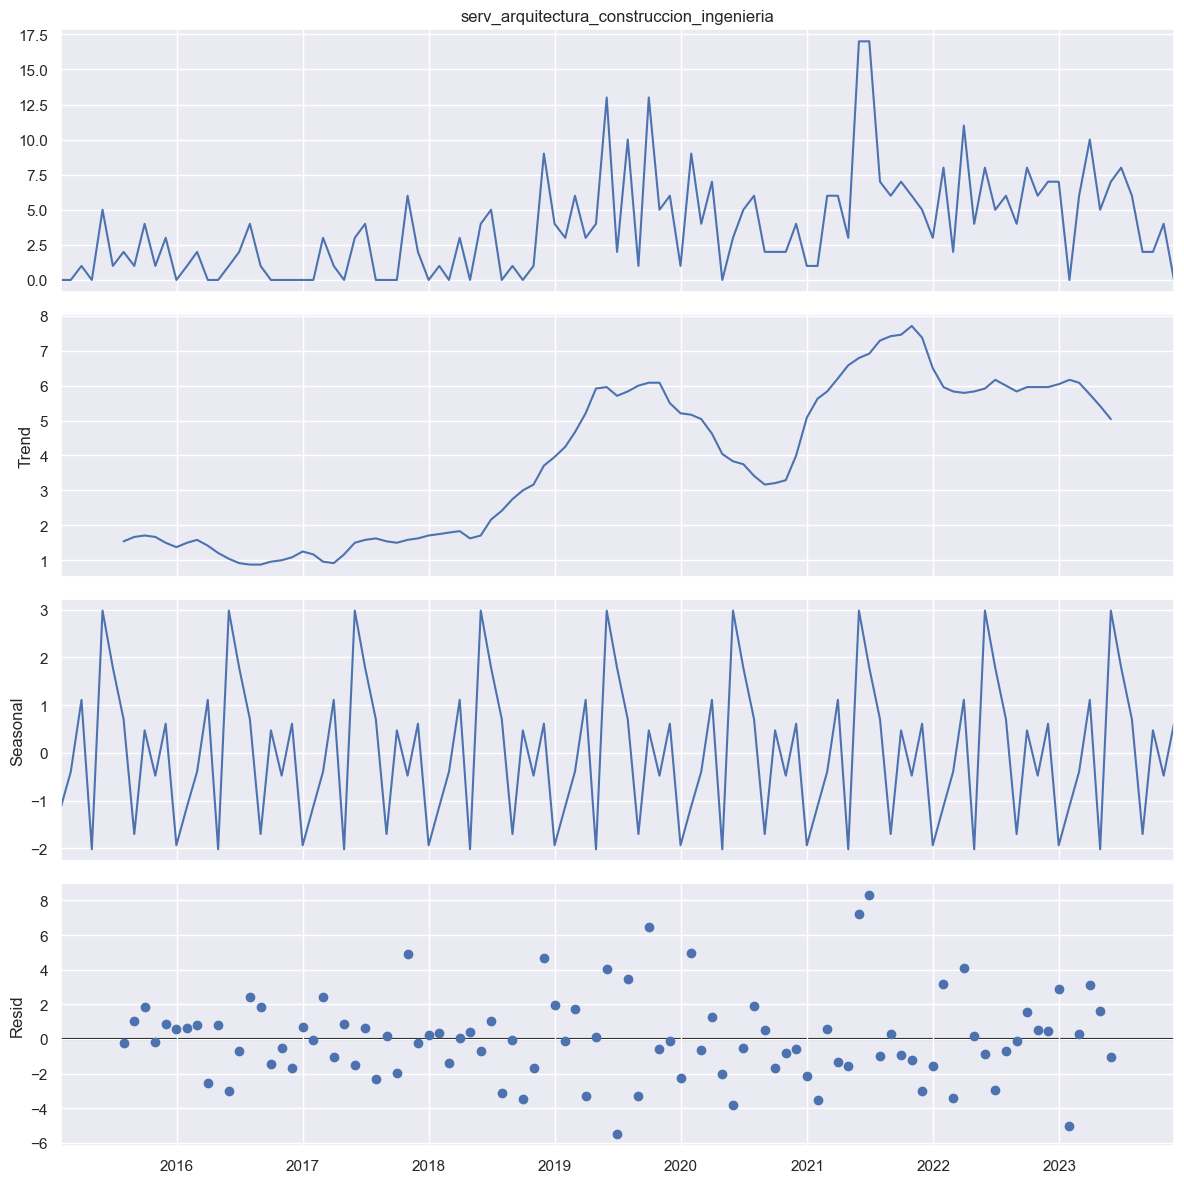

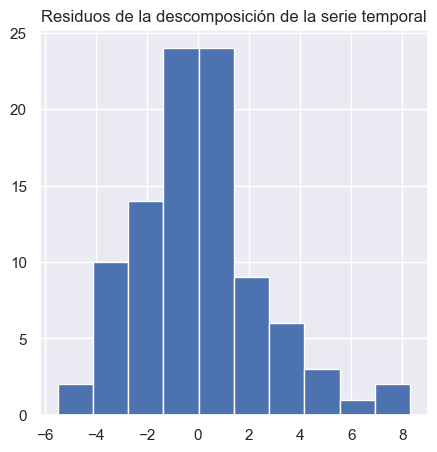

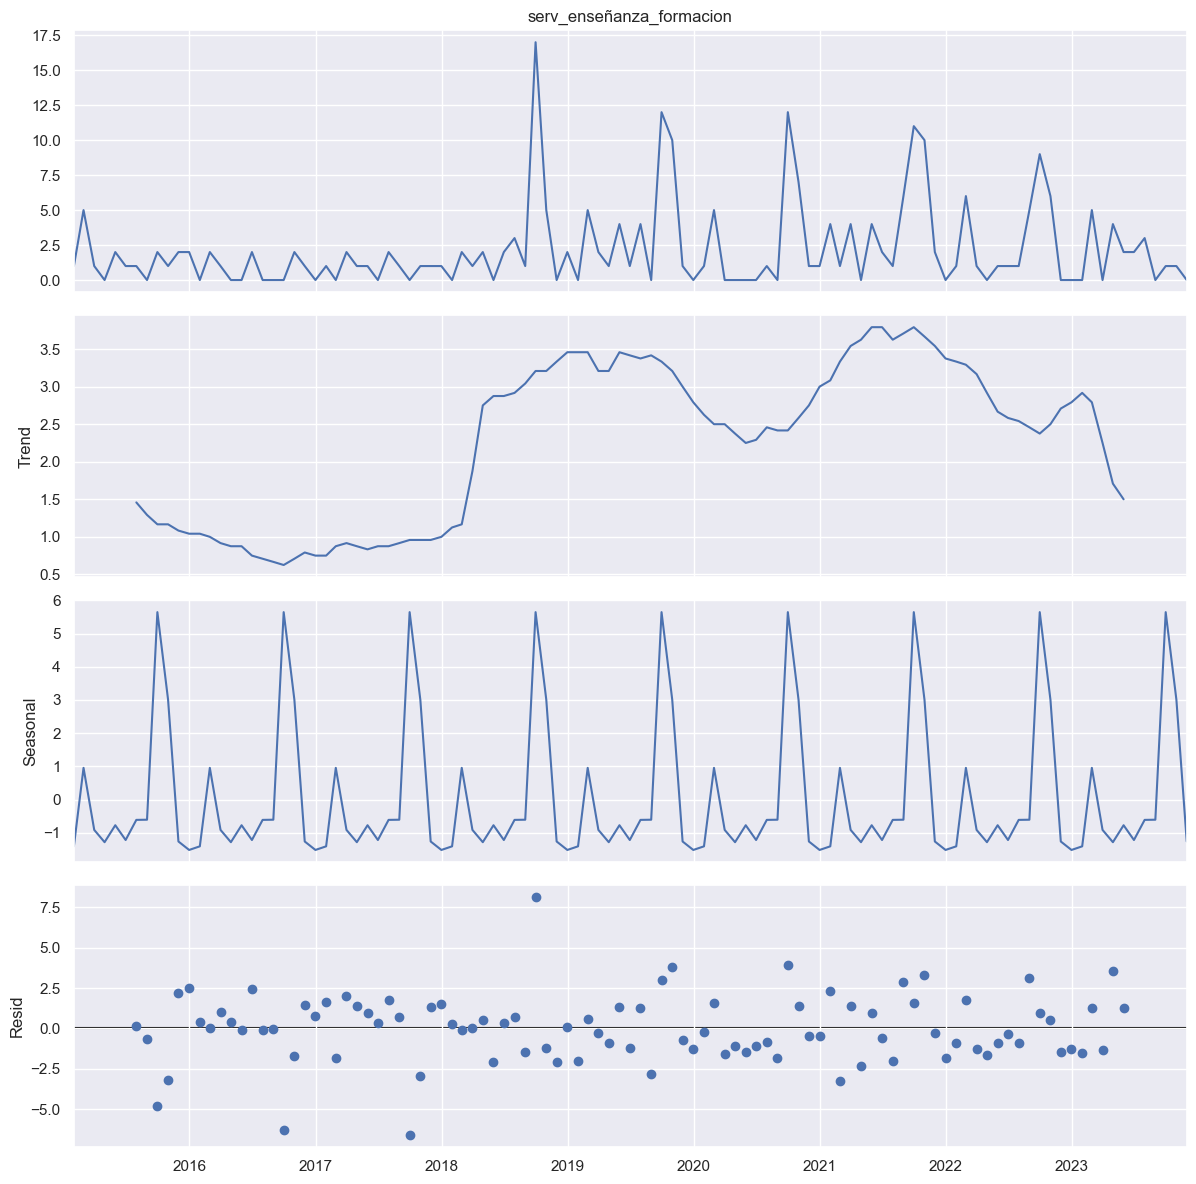

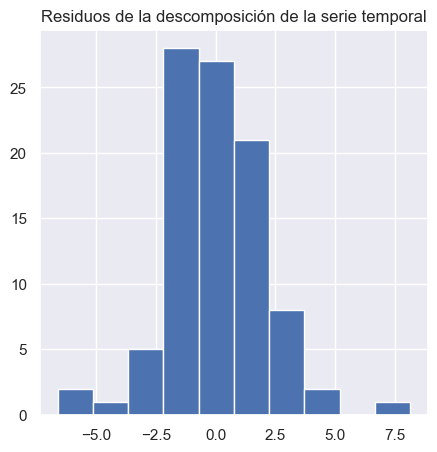

In [126]:
# aplico statsmodels: para cada clave en el diccionario 'resampleados'
df_tendencias = pd.DataFrame()
for key in resampleados.keys():
    result = seasonal_decompose(resampleados[key], model='additive')
    df_tendencias[key] = result.trend

    # Graficos de los componentes de la descomposición
    plt.rcParams['figure.figsize'] = [12,12]
    result.plot()
    plt.show()

    # Grafica los residuos de la descomposición
    residuos = result.resid
    plt.figure(figsize=[5,5])
    plt.hist(residuos)
    plt.title('Residuos de la descomposición de la serie temporal')
    plt.show()

Resumen observado en EDA:

* Limpieza de datos: quitar contratos menores y duplicidad en lotes. Formato datetime, tratamiento de nulos, generalización de CPV y selección de X e Y

* Exploración de datos: selección de variables de Y significativas, graficación y estudio de componentes en nuestra propia edicicón y en statsmodels.

Conlusiones: no estacionalidad también comprobado en entrenamiento por lo que nos quedamos con la tendencia, que es muy marcada, de la suma del resampleo por mes para entrenar y capturar esta. 

# Entrenamiento del modelo

### ONE - STEP 
Es un modelo simple y como se verá más adelante, hacer one step es lo que mejor funciona

In [127]:
#Periodos = mes
look_back = 6
N_train = 58 - look_back
N_test = 38

N_total = N_train + N_test
length_total = N_train + N_test + look_back
datos = {}
modelos = {}

for columna in promedio.columns:
    senial = promedio[columna]
    #Crear matrices de 0, luego se rellenan con datos
    N = senial.shape[0]
    X = np.zeros((N - look_back - 1, look_back))
    y = np.zeros(N - look_back - 1)

    for i in range(X.shape[0]):
        X[i,:] = senial.iloc[i:i+look_back]
        y[i] = senial.iloc[i+look_back]
    
    # Split
    X_train = X[:N_train,:]
    y_train = y[:N_train]

    X_test = X[N_train:N_train+N_test,:]
    y_test = y[N_train:N_train+N_test]
    
    # Almaceno X_train, y_train, X_test, y_test en el diccionario
    datos[columna] = (X_train, y_train, X_test, y_test)

In [128]:
param_grid = {'alpha': np.arange(0.01, 0.21, 0.01)}
lasso = Lasso(random_state=14)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=14)
resultados = pd.DataFrame(columns=['Variable', 'Alpha','Train RMSE', 'Train R2', 'Test RMSE', 'Test R2'])

variables = ['trabajos_construccion', 'serv_a empresas_legislacion_asesoria', 'serv_enseñanza_formacion', 'serv_arquitectura_construccion_ingenieria']

for var in variables:
    X_train, y_train, X_test, y_test = datos[var]
    grid = GridSearchCV(lasso, param_grid=param_grid, cv=cv)
    grid.fit(X_train, y_train)

    # Predicciones del mejor modelo con los datos de prueba
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)

    # Calculo del error cuadrático medio y el coeficiente de determinación
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    resultados = pd.concat([resultados, pd.DataFrame({
        'Variable': var,
        'Alpha': grid.best_params_['alpha'],
        'Train RMSE': train_rmse,
        'Train R2': train_r2,
        'Test RMSE': test_rmse,
        'Test R2': test_r2
    }, index=[0])], ignore_index=True)

C:\Users\perez\AppData\Local\Temp\ipykernel_9808\2606938513.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, pd.DataFrame({


In [129]:
pd.set_option('display.max_colwidth', None)
resultados

,Variable,Alpha,Train RMSE,Train R2,Test RMSE,Test R2
0,trabajos_construccion,0.02,0.343933,0.977968,0.524569,0.846537
1,serv_a empresas_legislacion_asesoria,0.01,0.297169,0.980436,0.420012,0.965865
2,serv_enseñanza_formacion,0.02,0.246921,0.952162,0.249952,0.815276
3,serv_arquitectura_construccion_ingenieria,0.01,0.316685,0.970612,0.474353,0.857828


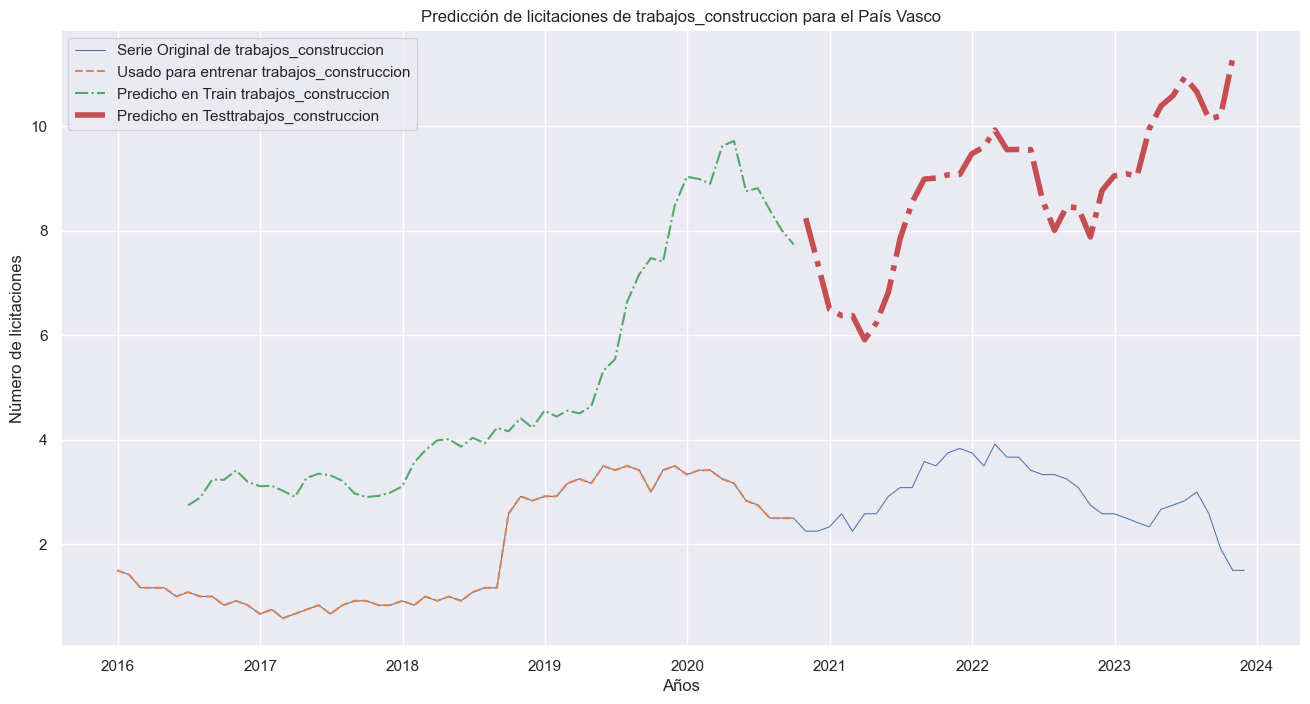

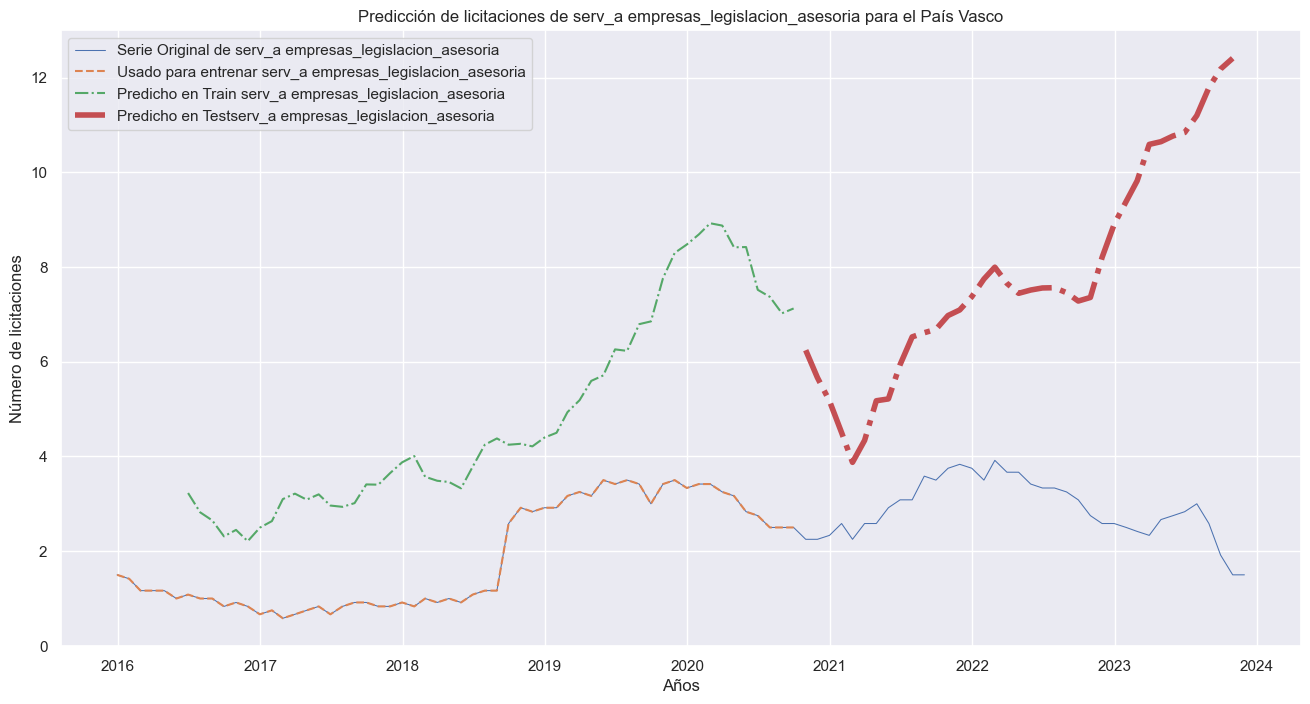

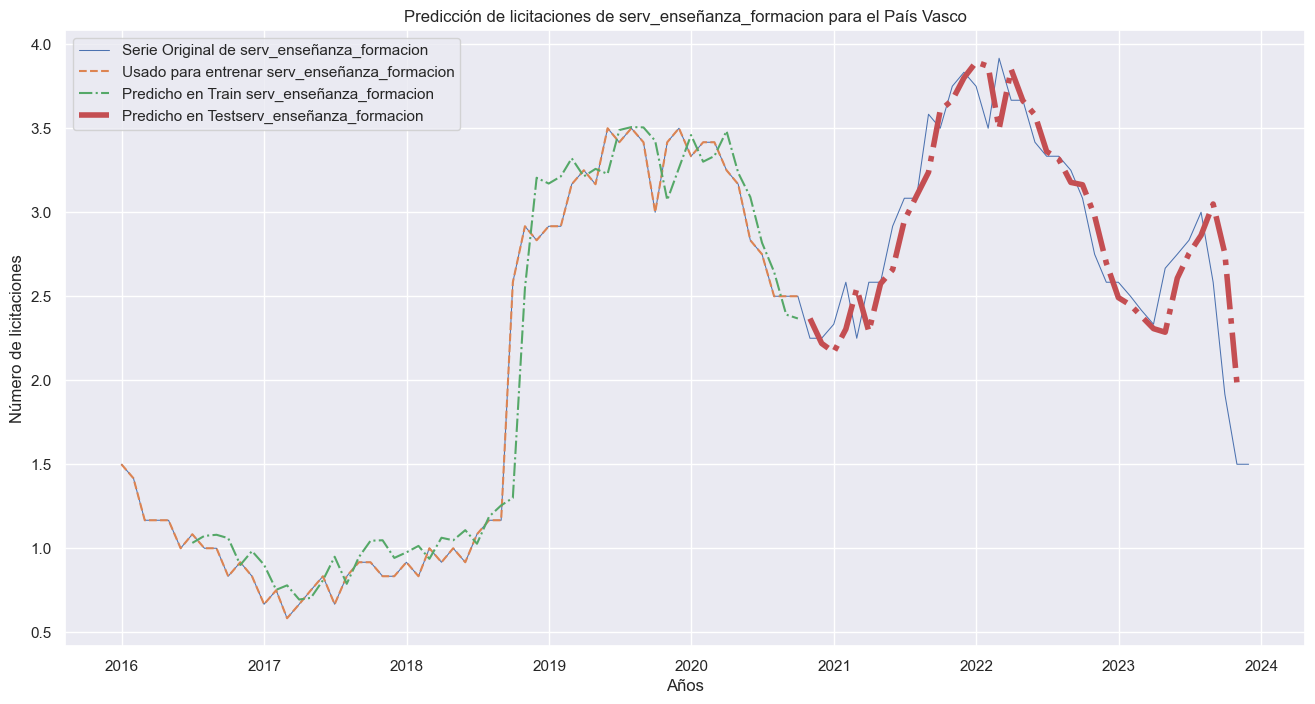

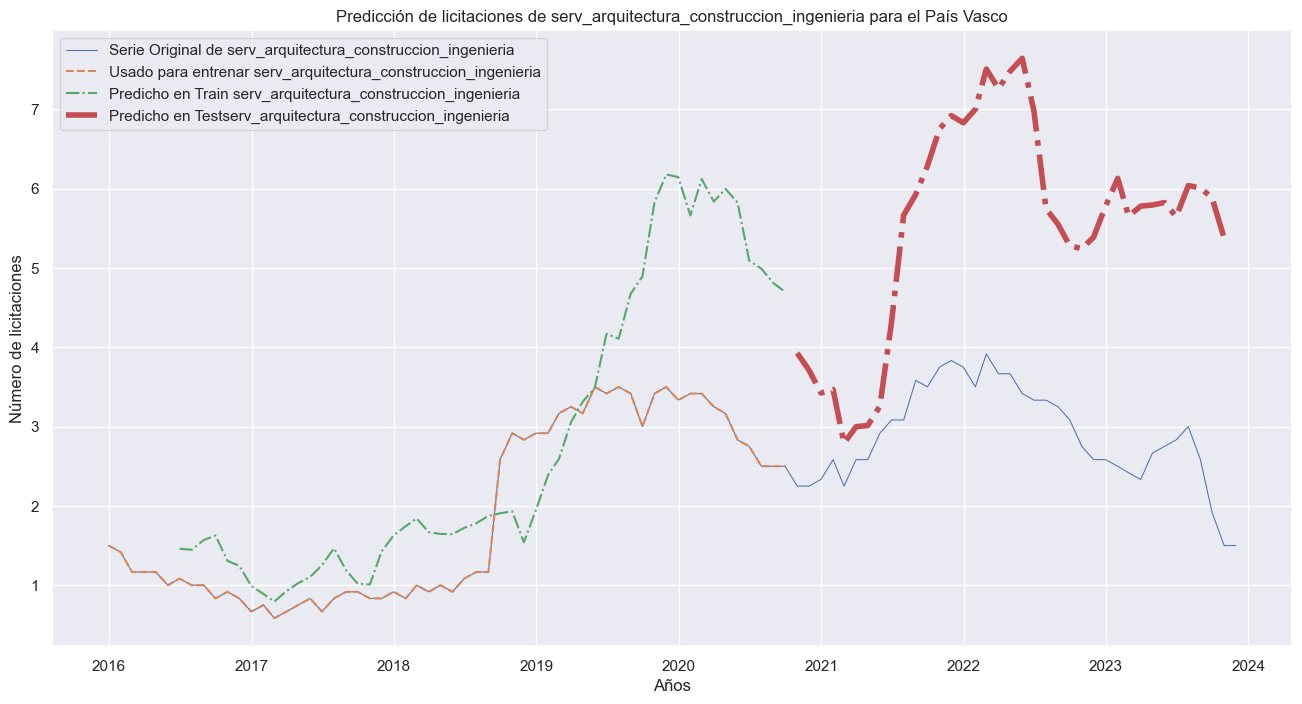

In [130]:
generar_graficos(variables, datos, grid, senial, length_total, N_train, look_back)

Predecir para diciembre de 2023

La predicción para diciembre de 2023 para trabajos_construccion es [1.49354262]
La predicción para diciembre de 2023 para serv_a empresas_legislacion_asesoria es [1.3538109]
La predicción para diciembre de 2023 para serv_arquitectura_construccion_ingenieria es [1.33074315]
La predicción para diciembre de 2023 para serv_enseñanza_formacion es [1.54694032]


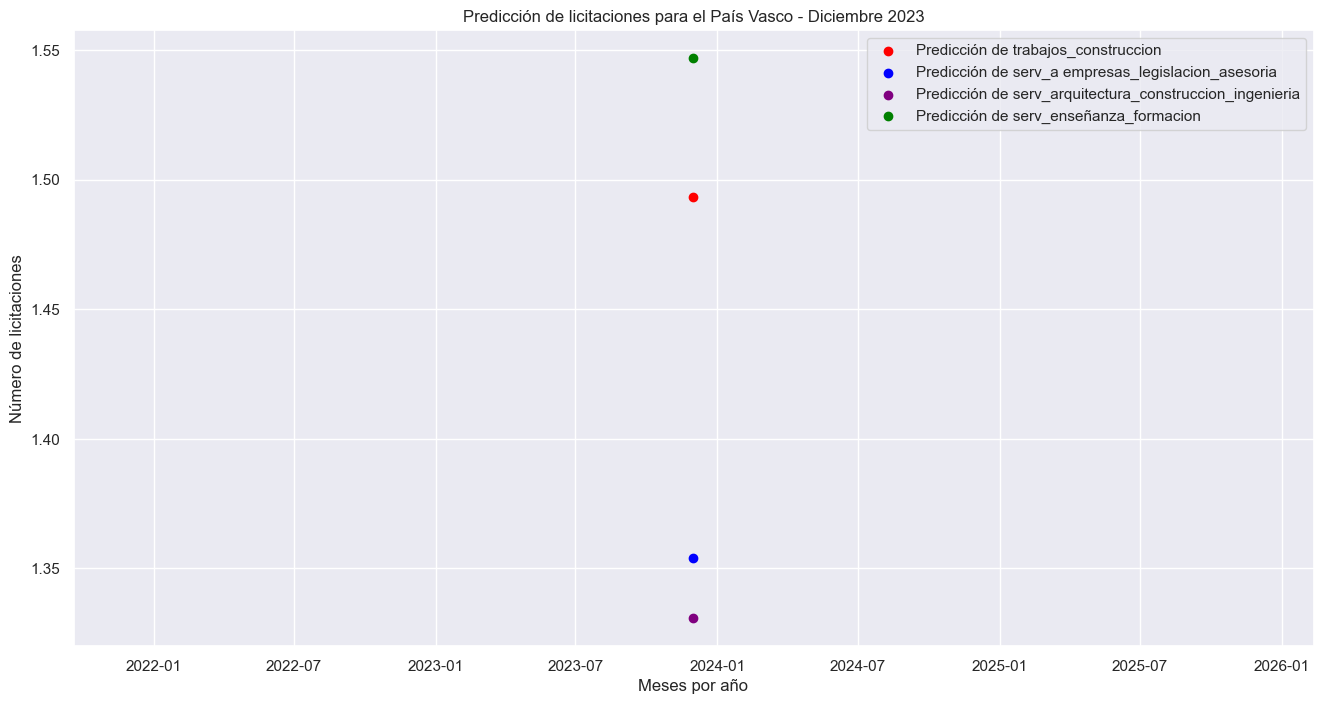

In [131]:
plt.figure(figsize=(16,8))
colores = {'trabajos_construccion': 'red', 'serv_a empresas_legislacion_asesoria': 'blue', 'serv_enseñanza_formacion': 'green', 'serv_arquitectura_construccion_ingenieria': 'purple'}
#predecir
for columna in promedio.columns:
    X_train, y_train, X_test, y_test = datos[columna]
    grid = GridSearchCV(lasso, param_grid=param_grid, cv=cv)
    grid.fit(X_train, y_train)
    X_new = senial[-look_back:].values.reshape(1, -1)
    y_pred = grid.predict(X_new)
    print(f"La predicción para diciembre de 2023 para {columna} es {y_pred}")
    fecha = datetime.datetime.strptime('2023-12-01', '%Y-%m-%d')
    plt.scatter(fecha, y_pred, color=colores[columna], label=f'Predicción de {columna}')

#Graficar
plt.legend()
plt.title('Predicción de licitaciones para el País Vasco - Diciembre 2023')
plt.xlabel('Meses por año')
plt.ylabel('Número de licitaciones')
plt.show()

### MULTI-STEP Y BENCHMARK 
En este caso no mejora

In [132]:
predicciones= {}
for var in variables:
    X_train, y_train, X_test, y_test = datos[var]
    y_ms_test_pred = []

    # Arrancamos con la primera instancia del conjunto de test
    x = X_test[0,:]
    for i in range(y_test.size):
        y_os_pred = grid.predict(x.reshape(1,-1))
        y_ms_test_pred.append(y_os_pred)
        x = np.append(x[1:], y_os_pred)

    y_ms_test_pred = np.array(y_ms_test_pred)
    predicciones[var] = y_ms_test_pred

    test_mse = mean_squared_error(y_test, y_ms_test_pred)
    test_r2 = r2_score(y_test, y_ms_test_pred)
    test_rmse = np.sqrt(test_mse)
    resultados = pd.concat([resultados, pd.DataFrame({
        'Variable': var,
        'Alpha': grid.best_params_['alpha'],
        'Train RMSE': 'N/A',  # No aplicable en el caso multistep
        'Train R2': 'N/A',  # No aplicable en el caso multistep
        'Test RMSE': test_rmse,
        'Test R2': test_r2
    }, index=[0])], ignore_index=True)
resultados

,Variable,Alpha,Train RMSE,Train R2,Test RMSE,Test R2
0,trabajos_construccion,0.02,0.343933,0.977968,0.524569,0.846537
1,serv_a empresas_legislacion_asesoria,0.01,0.297169,0.980436,0.420012,0.965865
2,serv_enseñanza_formacion,0.02,0.246921,0.952162,0.249952,0.815276
3,serv_arquitectura_construccion_ingenieria,0.01,0.316685,0.970612,0.474353,0.857828
4,trabajos_construccion,0.02,N/A,N/A,4.490932,-10.247905
5,serv_a empresas_legislacion_asesoria,0.02,N/A,N/A,4.803807,-3.465326
6,serv_enseñanza_formacion,0.02,N/A,N/A,0.693343,-0.421364
7,serv_arquitectura_construccion_ingenieria,0.02,N/A,N/A,2.795053,-3.936185


In [133]:
resultados = {}
# Recorrer las variables
for var in variables:
    # Obtener los datos de la variable
    X_train, y_train, X_test, y_test = datos[var]
    # Obtener las predicciones del mejor modelo con los datos de prueba
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)

    # Obtener los datos de la variable de referencia (benchmark)
    y_test_pred_benchmark = y[-1 + N_train:N_train+N_test - 1]
    # Convertir el objeto numpy.ndarray en una lista
    y_test_pred_benchmark = y_test_pred_benchmark.tolist()
    # Eliminar el último valor de la lista
    y_test_pred_benchmark.pop()

    # Calcular el error cuadrático medio (MSE) y el coeficiente de determinación (R2) para el modelo y el benchmark
    model_mse = mean_squared_error(y_test, y_test_pred)
    model_r2 = r2_score(y_test, y_test_pred)
    benchmark_mse = mean_squared_error(y_test, y_test_pred_benchmark)
    benchmark_r2 = r2_score(y_test, y_test_pred_benchmark)

    # Calcular el error cuadrático medio raíz (RMSE) como la raíz cuadrada del MSE
    model_rmse = np.sqrt(model_mse)
    benchmark_rmse = np.sqrt(benchmark_mse)

    # Guardar los resultados en el diccionario con el nombre de la variable como clave
    resultados[var] = [model_rmse, model_r2, benchmark_rmse, benchmark_r2]

# Crear un dataframe con el diccionario y asignarle un nombre a las filas y las columnas
resultados_bk = pd.DataFrame(resultados, index=['Test RMSE', 'Test R2', 'Benchmark RMSE', 'Benchmark R2'])

In [134]:
resultados_bk_transpuesto = resultados_bk.transpose()
resultados_bk_transpuesto

,Test RMSE,Test R2,Benchmark RMSE,Benchmark R2
trabajos_construccion,0.627422,0.780457,6.356067,-21.530746
serv_a empresas_legislacion_asesoria,0.566250,0.937956,5.765793,-5.432803
serv_enseñanza_formacion,0.249952,0.815276,0.251124,0.813541
serv_arquitectura_construccion_ingenieria,0.449100,0.872562,2.904317,-4.329660
